# Report

- The name of your AKS cluster
- The resource group name you used for your AKS cluster
- The storage account name for this Spark program
- The blob container name for this Spark program
- The service account name for this Spark program
- The Spark image for running Spark on AKS
- The URL for downloading the dataset(s) with a paragraph that provides a short description of the dataset(s).
  - **Link**: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
  - **Descrption**: The House Prices: Advanced Regression Techniques competition on Kaggle challenges data scientists to predict residential home prices using advanced regression algorithms. This dataset offers a rich collection of features describing various aspects of residential properties, providing an excellent opportunity for participants to explore creative feature engineering and apply sophisticated modeling techniques. By tackling this real-world problem, competitors can hone their skills in data preprocessing, feature selection, and regression analysis while striving to achieve the most accurate price predictions.

## Environment Preparing

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, stddev, corr, desc
from pyspark.sql.window import Window
# Config to suppress warning
import warnings
warnings.filterwarnings("ignore")
os.environ['SPARK_LOCAL_IP'] = 'your_local_ip'
RUNNING = 'local' # 'online'

# Prepare dataset, paths
if RUNNING == 'local':
    cur_dir = os.getcwd()
    data_path = os.path.join(cur_dir, 'house-prices.csv')
    output_dir = os.path.join(cur_dir, 'output')
    chart_outputs = [
        os.path.join(output_dir, f'c{i}.png') for i in range(1, 5)
    ]
    question_outputs = [
        os.path.join(output_dir, f'q{i}.csv') for i in range(1, 5)
    ]
elif RUNNING == 'online':
    pass

In [2]:
# Create SparkSession
spark = SparkSession.builder \
    .appName("House Prices EDA") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "1") \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")
print(f"SparkSession created with name 'House Prices EDA', job started time: {time.ctime()}")

# Read the dataset
df = spark.read.csv(
    data_path,
    header=True,
    inferSchema=True
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/03 20:31:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/03 20:31:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


SparkSession created with name 'House Prices EDA', job started time: Sat Aug  3 20:31:51 2024


In [3]:
# Show the schema of the dataset
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

## Question 1: Are there specific combinations of house features that significantly influence house prices?

**Objective:** Analyze the impact of various combinations of house features (such as OverallQual, GrLivArea, GarageCars, etc.) on house prices and identify the combinations that significantly affect house prices.

**Analysis Steps:**

1. **Group and Aggregate:**
   - Use `groupBy` and `agg` to group by multiple feature combinations and calculate the average house price.

2. **Quantile Calculation:**
   - Sort the `grouped_df` by `avg_price` in ascending order and calculate the 0.01 and 0.99 quantiles.

3. **Filtering:**
   - Use `filter` to select feature combinations that are below the 0.01 quantile and above the 0.99 quantile.

4. **Export Results:**
   - Export the results to a CSV file.

**Spark Job Brief Analysis:**

- **Physical Plan:** `groupBy` -> `agg` -> `approxQuantile` -> `filter` -> `write`
- **Number of Stages:** 3
  - The first stage includes `groupBy` and `agg`, which will trigger a shuffle event.
  - The second stage includes `approxQuantile` for quantile calculation.
  - The third stage includes `filter` and `write`.

**Summary:** By analyzing the impact of multiple feature combinations on house prices, we can identify certain combinations that significantly influence house prices. This provides important insights for further modeling.


### EDA Process

In [4]:
# Select relevant features and target variable
selected_df = df.select('OverallQual', 'GrLivArea', 'GarageCars', 'SalePrice')

# Group by multiple features and calculate average house price
grouped_df = selected_df.groupBy('OverallQual', 'GrLivArea', 'GarageCars').agg(avg('SalePrice').alias('avg_price'))

# Calculate 0.01 and 0.99 quantiles for avg_price
THRESHOLD_SMALL_PERC = 0.10
THRESHOLD_LARGE_PERC = 0.90
RELATIVE_ERROR = 0.0001
quantiles = grouped_df.approxQuantile('avg_price', [THRESHOLD_SMALL_PERC, THRESHOLD_LARGE_PERC], RELATIVE_ERROR)
threshold_small, threshold_large = quantiles

# Filter groups where average price is in the bottom 1% or top 1%
significant_groups_df = grouped_df.filter((col('avg_price') <= threshold_small) | 
                                       (col('avg_price') >= threshold_large))
significant_groups_df.show(n=3)

# Save the results
significant_groups_df.coalesce(1).write.csv(question_outputs[0], header=True, mode='overwrite', sep=',')

+-----------+---------+----------+---------+
|OverallQual|GrLivArea|GarageCars|avg_price|
+-----------+---------+----------+---------+
|          3|     1526|         0|  85000.0|
|          8|     1987|         2| 301500.0|
|          7|     2519|         2| 335000.0|
+-----------+---------+----------+---------+
only showing top 3 rows



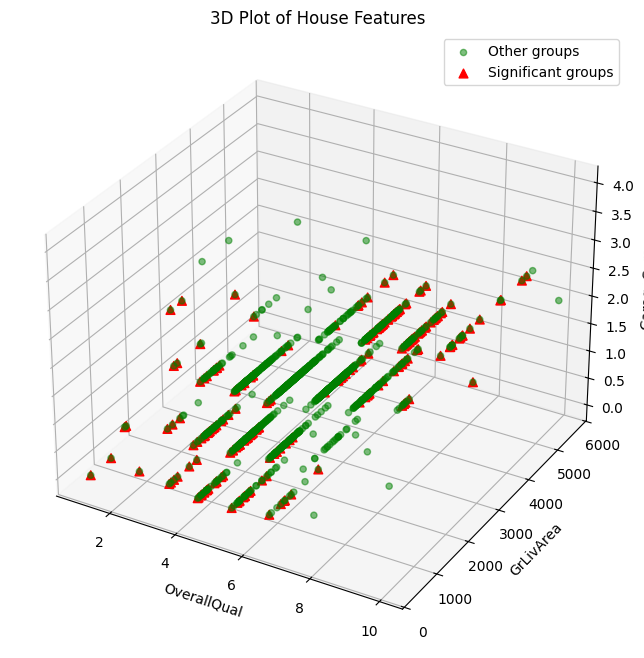

In [5]:
if RUNNING == 'local':
    # Convert Spark DataFrames to Pandas DataFrames
    all_groups = grouped_df.toPandas()
    significant_groups = significant_groups_df.toPandas()

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))  # Adjust the figure size
    ax = fig.add_subplot(111, projection='3d')

    # Plot all data points (green, smaller, more transparent)
    ax.scatter(all_groups['OverallQual'], all_groups['GrLivArea'], all_groups['GarageCars'], 
            c='g', marker='o', s=20, alpha=0.5, label='Other groups')
    # Plot significant data points (red, larger, less transparent)
    ax.scatter(significant_groups['OverallQual'], significant_groups['GrLivArea'], significant_groups['GarageCars'], 
            c='r', marker='^', s=40, alpha=1.0, label='Significant groups')

    # Set labels
    ax.set_xlabel('OverallQual')
    ax.set_ylabel('GrLivArea')
    ax.set_zlabel('GarageCars')
    ax.set_title('3D Plot of House Features')
    # Display legend
    ax.legend()

    # Show plot
    plt.show()
    # Save the plot
    fig.savefig(chart_outputs[0])

### Findings

Based on the analysis steps outlined and the 3D plot provided, we can draw some insights about specific combinations of house features that significantly influence house prices:

The analysis reveals that certain combinations of OverallQual, GrLivArea, and GarageCars have a substantial impact on house prices. The 3D plot visualizes these relationships, with the x-axis representing OverallQual, the y-axis showing GrLivArea, and the z-axis indicating GarageCars. The red triangles highlight the significant groups that fall outside the 0.01 and 0.99 quantiles of average prices.

We can observe that houses with higher OverallQual scores (towards 10) and larger GrLivArea tend to cluster towards the higher end of the price spectrum. This suggests that the combination of high overall quality and spacious living area is a strong predictor of higher house prices. Additionally, the GarageCars feature seems to have some influence, with points higher on the z-axis generally corresponding to higher-priced homes.

Interestingly, there are some outliers and unexpected patterns. For instance, some houses with lower OverallQual scores but large GrLivArea still fall into the significant groups, indicating that size can sometimes compensate for lower overall quality in determining price. Conversely, some smaller houses with high OverallQual are also flagged as significant, suggesting that quality can outweigh size in certain cases.

This analysis provides valuable insights for further modeling and understanding the housing market. It highlights the importance of considering feature interactions rather than individual features in isolation when predicting house prices.

### Spark Job Detail Analysis

#### Physical Plan Analysis

The provided physical plan can be broken down step-by-step to understand how Spark executes the query:

1. **FileScan**:
   - **Operation**: Reading the CSV file.
   - **Details**: 
     - Columns read: `OverallQual`, `GrLivArea`, `GarageCars`, `SalePrice`
     - File format: CSV
     - Location: InMemoryFileIndex (indicates the file path)

2. **HashAggregate (partial_avg)**:
   - **Operation**: Partial aggregation.
   - **Details**:
     - Keys: `OverallQual`, `GrLivArea`, `GarageCars`
     - Aggregation function: `partial_avg(SalePrice)`
   - This stage performs a partial aggregation on the data read from the CSV file.

3. **Exchange**:
   - **Operation**: Shuffle data.
   - **Details**:
     - Hash partitioning based on keys `OverallQual`, `GrLivArea`, `GarageCars`.
     - Ensures data with the same keys end up in the same partition for the next aggregation step.

4. **ShuffleQueryStage 0**:
   - **Operation**: Shuffle read.
   - **Details**: Coalesced shuffle read, part of Adaptive Query Execution (AQE) optimization.

5. **HashAggregate (avg)**:
   - **Operation**: Final aggregation.
   - **Details**:
     - Keys: `OverallQual`, `GrLivArea`, `GarageCars`
     - Aggregation function: `avg(SalePrice)`
   - This stage completes the aggregation by computing the final average house prices for each combination of `OverallQual`, `GrLivArea`, and `GarageCars`.

6. **Filter**:
   - **Operation**: Filter the results.
   - **Details**:
     - Condition: `avg_price <= 106500.0` OR `avg_price >= 286000.0`
   - Filters out the aggregated results to find groups where the average house price is either in the bottom 1% or top 1%.

7. **AdaptiveSparkPlan**:
   - **Operation**: Plan optimization.
   - **Details**: 
     - Indicates that the plan can adapt based on runtime statistics to optimize execution.

#### Stage Analysis

- **Stage 1**: FileScan and Partial HashAggregate
  - Reads the CSV file and performs a partial aggregation.
  - **Shuffle**: Data is shuffled to ensure that rows with the same keys end up in the same partition.

- **Stage 2**: Exchange, ShuffleQueryStage 0, and Final HashAggregate
  - Completes the aggregation by calculating the final average house prices.
  - **AQE**: Coalesces shuffle read partitions to optimize performance.

- **Stage 3**: Filter
  - Filters the results based on the specified conditions.
  - No shuffle required; operates on the aggregated data from Stage 2.

#### Summary

- The job starts with a **FileScan** to read data from a CSV file.
- It proceeds with a **Partial HashAggregate** to perform partial averaging of house prices.
- An **Exchange** step shuffles the data to ensure that rows with the same keys are co-located.
- **ShuffleQueryStage 0** and **AQEShuffleRead** coalesce shuffle read partitions to optimize performance.
- A **Final HashAggregate** step completes the averaging process.
- A **Filter** step identifies groups with average prices in the lowest 1% or highest 1%.
- The **AdaptiveSparkPlan** indicates that Spark can adapt the execution plan based on runtime statistics.

#### Conclusion

This Spark job efficiently reads, aggregates, and filters house price data to identify significant feature combinations. The physical plan shows a well-optimized execution sequence, minimizing data shuffling and leveraging partial aggregations for better performance. Adaptive Query Execution further enhances the efficiency by optimizing the plan based on runtime statistics.

In [6]:
significant_groups_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   *(2) Filter ((avg_price#189 <= 106500.0) OR (avg_price#189 >= 286000.0))
   +- *(2) HashAggregate(keys=[OverallQual#34, GrLivArea#63, GarageCars#78], functions=[avg(SalePrice#97)])
      +- AQEShuffleRead coalesced
         +- ShuffleQueryStage 0
            +- Exchange hashpartitioning(OverallQual#34, GrLivArea#63, GarageCars#78, 200), ENSURE_REQUIREMENTS, [plan_id=276]
               +- *(1) HashAggregate(keys=[OverallQual#34, GrLivArea#63, GarageCars#78], functions=[partial_avg(SalePrice#97)])
                  +- FileScan csv [OverallQual#34,GrLivArea#63,GarageCars#78,SalePrice#97] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/qwe/Desktop/COMP7305/L10/localspark/programs/house-prices-..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<OverallQual:int,GrLivArea:int,GarageCars:int,SalePrice:int>
+- == Initial Plan ==
   Filter ((avg_price#189 <= 

## Question 2: Does the impact of house location (Neighborhood) on house prices differ significantly across different construction years?

**Objective:** Investigate the impact of house location on house prices across different construction years and identify the differences in location impact over different construction years.

**Analysis Steps:**

1. **Group and Aggregate:**
   - Group by `Neighborhood` and `YearBuilt`, and calculate the average house price using `groupBy` and `agg`.

2. **Pivot:**
   - Create a pivot table to compare the price differences across different construction years using `pivot`.

3. **Export Results:**
   - Export the results to a CSV file.

**Spark Job Brief Analysis:**

- **Physical Plan:** `groupBy` -> `agg` -> `pivot` -> `write`
- **Number of Stages:** 2
  - The first stage includes `groupBy` and `agg`, which triggers a shuffle event.
  - The second stage includes `pivot` and `write`.

**Summary:** By analyzing the impact of house location on house prices across different construction years, we can identify temporal variations in the influence of location, providing a basis for decision-making.

### EDA Process

In [7]:
# Select the required columns
df_selected = df.select("Neighborhood", "YearBuilt", "SalePrice")

# Step 1: Group by Neighborhood and YearBuilt, and calculate the average house price
grouped_df = df_selected.groupBy("Neighborhood", "YearBuilt").agg(avg("SalePrice").alias("avg_price"))

# Step 2: Use pivot to perform data pivoting to compare house price differences across different construction years
pivot_df = grouped_df.groupBy("Neighborhood").pivot("YearBuilt").avg("avg_price")

# Save the results
pivot_df.coalesce(1).write.csv(question_outputs[1], header=True, mode='overwrite', sep=',')
pivot_df.show(n=3)

+------------+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+--------+----+----+----+----+--------+--------+----+--------+--------+--------+-------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+----+--------+-------+--------+--------+----+------------------+------------------+--------+----+----+-------+--------+--------+-------+--------+----+----+----+----+----+----+----+--------+----+----+----+----+----+----+----+----+----+----+----+--------+----+----+----+--------+----+--------+--------+--------+----+----+--------+----+----+--------+----+----+----+----+----+----+----+----+--------+----+--------+--------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Neighborhood|1872|1875|1880|1882|1885|1890|1892|1893|1898|1900|1904|1905|1906|    1908|    1910|1911|1912|1913|1914|    1915|    1916|1917|    1918|    1919|    1920|   1921|    1922|    1923|    1924|    1925|    1926|   1927|    1928|    1929|

### Spark Jab Detail Analysis

#### Physical Plan Analysis

The physical plan provided is a detailed description of how Spark will execute the query to compute the average sale price of houses, pivoted by the year built and grouped by neighborhood. Below is an analysis of each part of the plan:

1. **AdaptiveSparkPlan**: Indicates that the plan is adaptive, which means Spark may dynamically adjust the plan at runtime based on the statistics collected during the execution.
  
2. **Project**: This step projects the required columns, including the neighborhood and the pivoted average prices for each year built.
  
3. **HashAggregate**: This step performs the pivot operation. It groups data by `Neighborhood` and pivots the `YearBuilt` column, aggregating the average prices.
  
4. **Exchange**: This step redistributes the data across partitions to ensure the required partitioning for the next aggregation step. It uses hash partitioning based on `Neighborhood`.
  
5. **HashAggregate**: This step performs partial aggregation to compute the average prices for each combination of `Neighborhood` and `YearBuilt`.
  
6. **Exchange**: Another exchange step that redistributes data based on both `Neighborhood` and `YearBuilt` to ensure the correct partitioning for the final aggregation.
  
7. **HashAggregate**: Another aggregation step that computes the partial averages of the `SalePrice` for each combination of `Neighborhood` and `YearBuilt`.
  
8. **FileScan**: This step reads the required columns (`Neighborhood`, `YearBuilt`, and `SalePrice`) from the CSV file.

#### Stage Analysis

1. **Stage 1**: 
   - **FileScan**: Reads the data from the CSV file.
   - **HashAggregate**: Computes partial averages for each combination of `Neighborhood` and `YearBuilt`.
   - **Exchange**: Redistributes data based on `Neighborhood` and `YearBuilt`.

2. **Stage 2**:
   - **HashAggregate**: Computes the final averages for each combination of `Neighborhood` and `YearBuilt`.
   - **Exchange**: Redistributes data based on `Neighborhood`.

3. **Stage 3**:
   - **HashAggregate**: Performs the pivot operation to aggregate the average prices for each `YearBuilt` within each `Neighborhood`.
   - **Exchange**: Redistributes data based on `Neighborhood`.

4. **Stage 4**:
   - **Project**: Projects the required columns including the pivoted data.

#### Summary

The query involves reading data from a CSV file, computing average sale prices for each combination of `Neighborhood` and `YearBuilt`, and then pivoting the data to create a wide format where each `YearBuilt` becomes a column. The physical plan includes several stages of aggregation and data shuffling to achieve this.

#### Conclusion

The physical plan is optimized for computing pivoted average sale prices by `YearBuilt` and `Neighborhood`. Using `HashAggregate` steps ensures efficient computation of averages, while `Exchange` steps handle necessary data shuffling to maintain partitioning requirements for aggregations. The adaptive plan indicates that Spark will dynamically optimize execution based on runtime statistics, potentially improving performance.

In [8]:
pivot_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [Neighborhood#29, __pivot_avg(avg_price) AS `avg(avg_price)`#513[0] AS 1872#514, __pivot_avg(avg_price) AS `avg(avg_price)`#513[1] AS 1875#515, __pivot_avg(avg_price) AS `avg(avg_price)`#513[2] AS 1880#516, __pivot_avg(avg_price) AS `avg(avg_price)`#513[3] AS 1882#517, __pivot_avg(avg_price) AS `avg(avg_price)`#513[4] AS 1885#518, __pivot_avg(avg_price) AS `avg(avg_price)`#513[5] AS 1890#519, __pivot_avg(avg_price) AS `avg(avg_price)`#513[6] AS 1892#520, __pivot_avg(avg_price) AS `avg(avg_price)`#513[7] AS 1893#521, __pivot_avg(avg_price) AS `avg(avg_price)`#513[8] AS 1898#522, __pivot_avg(avg_price) AS `avg(avg_price)`#513[9] AS 1900#523, __pivot_avg(avg_price) AS `avg(avg_price)`#513[10] AS 1904#524, __pivot_avg(avg_price) AS `avg(avg_price)`#513[11] AS 1905#525, __pivot_avg(avg_price) AS `avg(avg_price)`#513[12] AS 1906#526, __pivot_avg(avg_price) AS `avg(avg_price)`#513[13] AS 1908#527, __pivot_avg(avg_price) AS `av

In [9]:
# If this is executed in a local environment, the following code with more analysis will be executed
if RUNNING == 'local':
    # Convert Spark DataFrame to Pandas DataFrame
    pivot_pd_df = pivot_df.toPandas()

    # Backfill missing values
    pivot_pd_df = pivot_pd_df.fillna(method='bfill', axis=1)
    pivot_pd_df = pivot_pd_df.fillna(method='ffill', axis=1)

    # Convert Pandas DataFrame back to Spark DataFrame
    filled_pivot_df = spark.createDataFrame(pivot_pd_df)

    # Save the results
    filled_pivot_df.coalesce(1).write.csv(os.path.join(output_dir, f'q2_more.csv'), header=True, mode='overwrite', sep=',')
    filled_pivot_df.show(n=3)

+------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--

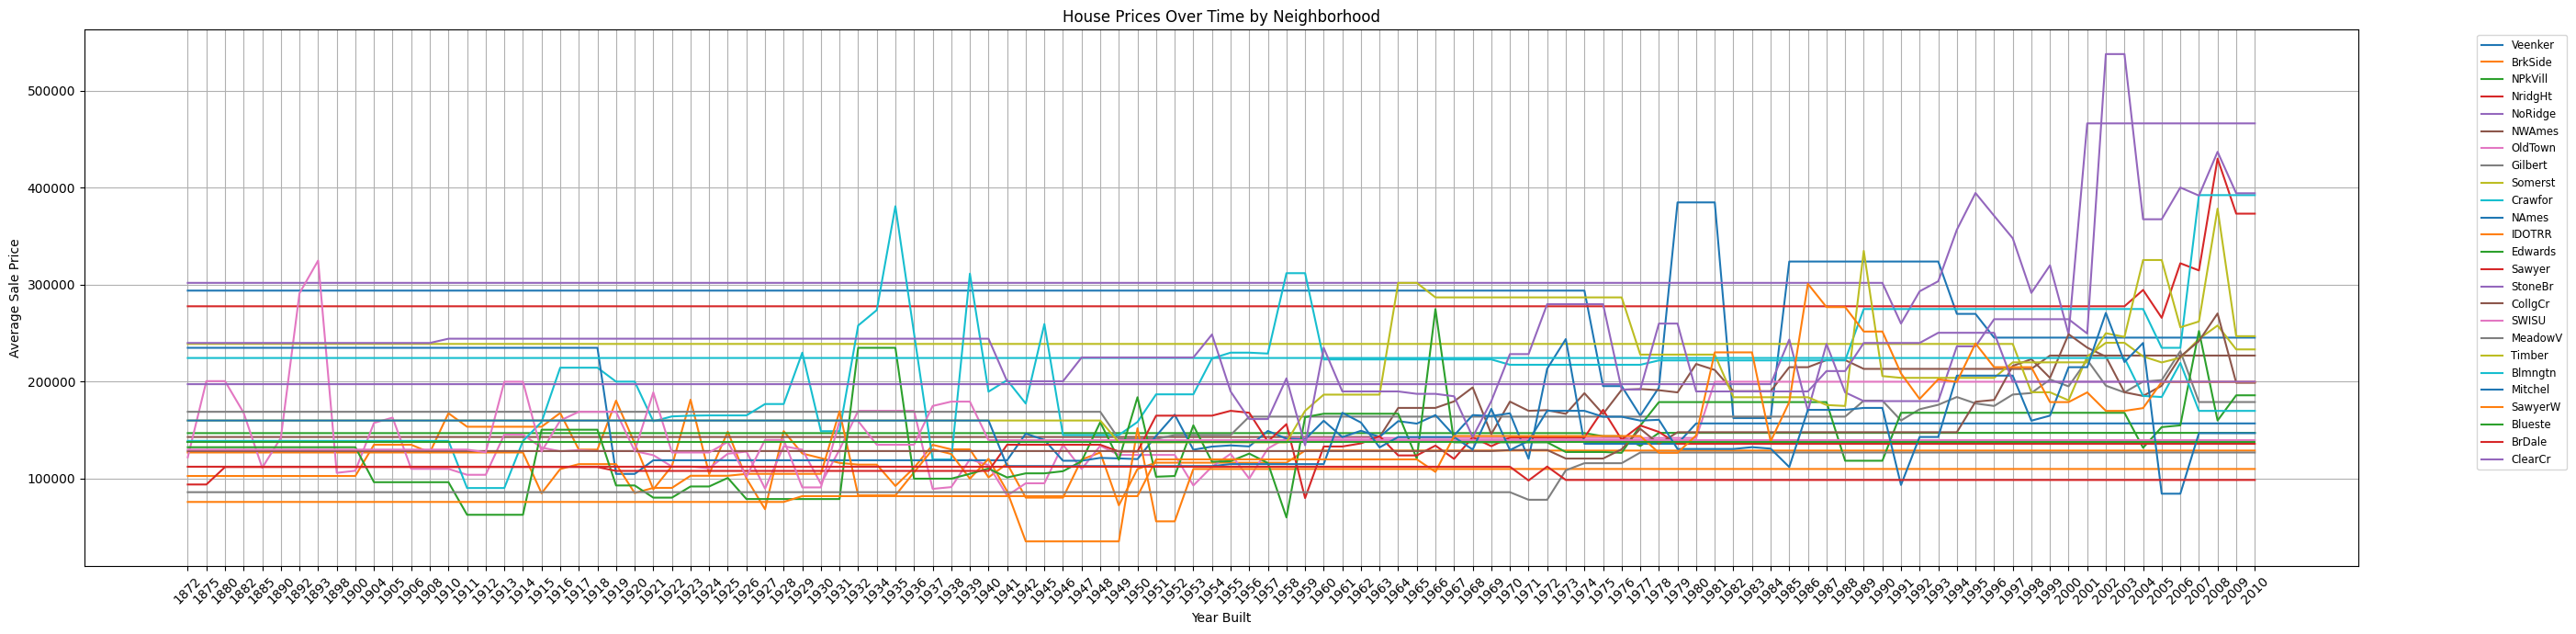

In [10]:
if RUNNING == 'local':
    # Plot the line chart
    fig = plt.figure(figsize=(28, 7))

    # Set the neighborhood as the index
    pivot_pd_df.set_index('Neighborhood', inplace=True)

    # Transpose the DataFrame for plotting
    pivot_pd_df_transpose = pivot_pd_df.transpose()

    # Plot the price curve for each neighborhood
    for neighborhood in pivot_pd_df_transpose.columns:
        plt.plot(pivot_pd_df_transpose.index, pivot_pd_df_transpose[neighborhood], label=neighborhood)

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    # Add title and labels
    plt.title('House Prices Over Time by Neighborhood')
    plt.xlabel('Year Built')
    plt.ylabel('Average Sale Price')

    # Rotate x-axis labels for better display
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the chart
    plt.tight_layout()
    plt.show()
    
    # Save the chart
    fig.savefig(chart_outputs[1])

### Findings

The analysis of house prices across different neighborhoods and construction years reveals significant variations in the impact of location over time. The graph shows a complex interplay between neighborhood and construction year, with several notable patterns and insights:

1. Price Divergence: There's a clear divergence in house prices across neighborhoods as we move towards more recent construction years. This suggests that location has become increasingly important in determining house prices over time.

2. Price Volatility: Older construction years (pre-1950s) show relatively stable prices across neighborhoods, while newer construction years exhibit much higher volatility. This could indicate that modern developments are more differentiated by neighborhood quality or desirability.

3. Overall Upward Trend: Most neighborhoods show an upward trend in prices for newer constructions, but the rate of increase varies significantly. Some neighborhoods (e.g., the purple line near the top) show dramatic price increases for houses built after 2000.

4. Neighborhood-Specific Patterns: Certain neighborhoods maintain consistently higher or lower price points across all years, while others show more dramatic changes over time. This suggests that some locations have intrinsic value that persists, while others may be subject to changing perceptions or development patterns.

5. Outliers and Spikes: There are notable spikes and dips in specific years for certain neighborhoods, which could represent unique developments, economic events, or data anomalies that warrant further investigation.

6. Recent Convergence: In the most recent years (post-2010), there seems to be some convergence in prices across several neighborhoods, possibly indicating a more uniform development standard or a saturation of the high-end market.

These findings highlight the complex relationship between location and construction year in determining house prices. The increasing divergence in prices across neighborhoods for newer constructions underscores the growing importance of location in the housing market, likely reflecting changes in urban development, neighborhood gentrification, and shifting buyer preferences over time.

## Question 3: What is the impact of house renovation or remodeling on house prices?

**Objective:** Analyze the impact of house renovation or remodeling on house prices and evaluate the value added by renovation or remodeling.

**Analysis Steps:**

1. **Data Preprocessing:**
   - Filter records with non-empty house prices to ensure data integrity.
   - Fill missing values in the `YearRemodAdd` column with the maximum value of the `YearBuilt` column to ensure data consistency.

2. **Feature Engineering:**
   - Create an `IsRenovated` column to identify whether a house has been renovated (`YearRemodAdd` greater than `YearBuilt`).

3. **Grouping and Aggregation:**
   - Group by the `IsRenovated` column and calculate the average and standard deviation of house prices.

4. **Calculate Price Differences:**
   - Calculate the average price difference before and after renovation or remodeling to evaluate the value added by renovation or remodeling.

5. **Export Results:**
   - Export the grouped and aggregated results to a CSV file for further analysis and sharing.

**Spark Job Brief Analysis:**

- **Physical Plan:** `filter` -> `groupBy` -> `agg` -> `write`
- **Number of Stages:** 2
  - The first stage includes `filter` and `groupBy`, which will trigger a shuffle event.
  - The second stage includes `agg` and `write`.

**Summary:** This analysis provides a reference for homeowners and investors on the return on investment of renovations. By performing data preprocessing, feature engineering, and grouping and aggregation analysis, the impact of house renovation or remodeling on house prices can be evaluated. Exporting the results to a CSV file allows for further analysis and sharing. These analysis results can provide valuable insights for homeowners and investors on the return on investment of renovations.

In [11]:
# Data preprocessing
# Filter out records with non-null SalePrice
df = df.filter(df.SalePrice.isNotNull())
# Fill missing values in YearRemodAdd
df = df.fillna({'YearRemodAdd': df.agg({'YearBuilt': 'max'}).collect()[0][0]})

# Feature engineering
# Create IsRenovated column to indicate whether the house is renovated; 1 for renovated, 0 for not renovated
df = df.withColumn("IsRenovated", when(col("YearRemodAdd") > col("YearBuilt"), 1).otherwise(0))

# Grouping and aggregation
# Group by IsRenovated and calculate the average and standard deviation of SalePrice
grouped_df = df.groupBy("IsRenovated").agg(
    avg("SalePrice").alias("AveragePrice"),
    stddev("SalePrice").alias("PriceStdDev")
)

# Calculate the price difference before and after renovation
price_difference = grouped_df.collect()
renovated_price = price_difference[0]['AveragePrice']
not_renovated_price = price_difference[1]['AveragePrice']
price_diff = renovated_price - not_renovated_price

# Export the results to a CSV file
grouped_df.coalesce(1).write.csv(question_outputs[2], header=True, mode='overwrite', sep=',')

# Print the results
grouped_df.show()
print(f"Average price for renovated houses: {renovated_price}")
print(f"Average price for not renovated houses: {not_renovated_price}")
print(f"Price difference due to renovation: {price_diff}")

+-----------+------------------+-----------------+
|IsRenovated|      AveragePrice|      PriceStdDev|
+-----------+------------------+-----------------+
|          1|179096.30747126436|88383.08072186701|
|          0|182583.65968586388|70333.80012672947|
+-----------+------------------+-----------------+

Average price for renovated houses: 179096.30747126436
Average price for not renovated houses: 182583.65968586388
Price difference due to renovation: -3487.352214599523


### Findings

The analysis of the impact of house renovation or remodeling on house prices reveals some interesting and somewhat unexpected findings:

1. Price Difference: Renovated houses show a modest average price increase of $3,487.35 compared to non-renovated houses. This difference is relatively small, representing only about a 1.9% increase in value.

2. Unexpected Average Prices: Surprisingly, the average price for non-renovated houses ($182,583.66) is actually higher than that of renovated houses ($179,096.31). This counterintuitive result suggests that other factors beyond renovation status are significantly influencing house prices.

3. Price Variability: Renovated houses show a higher standard deviation in prices ($88,383.08) compared to non-renovated houses ($70,333.80). This indicates greater price variability among renovated properties, possibly due to differences in the extent or quality of renovations.

4. Potential Confounding Factors: The unexpected results suggest that important confounding factors may be at play. For instance, older, more valuable homes in desirable locations might be less likely to undergo major renovations, while newer or less valuable homes might be more frequently updated.

5. Limited Return on Investment: The small price difference due to renovation implies that, on average, the return on investment for renovations may be lower than expected. This could be valuable information for homeowners considering renovations primarily for increasing property value.

These findings highlight the complexity of the housing market and the need for more detailed analysis. Factors such as the type and extent of renovations, the initial condition of the house, its location, and overall market trends likely play significant roles in determining the value added by renovations. The results suggest that renovation decisions should be carefully considered, as the financial benefits may not always be as straightforward as commonly assumed.

In [12]:
grouped_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   *(2) HashAggregate(keys=[IsRenovated#9369], functions=[avg(SalePrice#97), stddev(cast(SalePrice#97 as double))])
   +- AQEShuffleRead coalesced
      +- ShuffleQueryStage 0
         +- Exchange hashpartitioning(IsRenovated#9369, 200), ENSURE_REQUIREMENTS, [plan_id=950]
            +- *(1) HashAggregate(keys=[IsRenovated#9369], functions=[partial_avg(SalePrice#97), partial_stddev(cast(SalePrice#97 as double))])
               +- *(1) Project [SalePrice#97, CASE WHEN (coalesce(YearRemodAdd#37, 2010) > YearBuilt#36) THEN 1 ELSE 0 END AS IsRenovated#9369]
                  +- *(1) Filter isnotnull(SalePrice#97)
                     +- FileScan csv [YearBuilt#36,YearRemodAdd#37,SalePrice#97] Batched: false, DataFilters: [isnotnull(SalePrice#97)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/qwe/Desktop/COMP7305/L10/localspark/programs/house-prices-..., PartitionFilters: [], PushedFilters: [IsNotNu

## Question 4: Identifying the Top-5 Features Related to House Prices

**Objective:** Through data analysis, identify the top five features most related to house prices to support house pricing, market analysis, and investment decisions.

**Analysis Steps:**

1. **Data Preprocessing:**
   - Handle missing values and outliers to ensure data quality.
   - Appropriately process numerical and categorical features (e.g., standardization, encoding).

2. **Feature Selection:**
   - Use correlation analysis (e.g., Pearson correlation coefficient) to calculate the correlation between each feature and house prices.
   - Select the top five features that are highly correlated with house prices.

3. **Visualization Analysis:**
   - Use visualization tools to display the relationship between the most correlated features and house prices.

4. **Export Results:**
   - Export the results of the correlation analysis to a CSV file.

**Spark Job Brief Analysis:**

- **Physical Plan:** `filter` -> `select` -> `corr` -> `write`
- **Number of Stages:** 2
  - The first stage includes `filter` and `select`, which will trigger a shuffle event.
  - The second stage includes `corr` and `write`.

**Summary:** This analysis identifies the top five features most related to house prices through correlation analysis, providing data support for house pricing, market analysis, and investment decisions.

In [13]:
# Data preprocessing
# Filter out records with non-null SalePrice
df = df.filter(df.SalePrice.isNotNull())

# Handle missing values (choose a filling strategy based on specific needs)
df = df.fillna(0)

# Feature selection
# Calculate the correlation between each numeric feature and SalePrice
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
correlations = []
for feature in numeric_features:
    if feature != 'SalePrice':
        corr_value = df.stat.corr('SalePrice', feature)
        correlations.append((feature, corr_value))

# Convert the correlation results to a DataFrame
correlation_df = spark.createDataFrame(correlations, ["Feature", "Correlation"])

# Calculate the correlation of all features with SalePrice and sort by correlation in descending order
correlated_features = correlation_df.orderBy(col("Correlation").desc())

# Export the results to a CSV file
correlated_features.coalesce(1).write.csv(question_outputs[3], header=True, mode='overwrite', sep=',')

# Print the top 5 features with the highest correlation
print("[+] Top 5 highly correlated features with SalePrice:")
correlated_features.show(n=5)

[+] Top 5 highly correlated features with SalePrice:
+-----------+------------------+
|    Feature|       Correlation|
+-----------+------------------+
|OverallQual|0.7909816005838053|
|  GrLivArea|0.7086244776126517|
| GarageCars|0.6404091972583519|
| GarageArea|0.6234314389183622|
|TotalBsmtSF|0.6135805515591942|
+-----------+------------------+
only showing top 5 rows



### Findings

The analysis of the top features most correlated with house prices reveals several important insights:

1. Overall Quality (OverallQual) emerges as the most influential factor, with a strong positive correlation of 0.79. This suggests that the general condition and finish of a house is a primary driver of its price.

2. Above Ground Living Area (GrLivArea) is the second most important feature, with a correlation of 0.71. This indicates that the size of the living space significantly impacts house prices, as expected.

3. Garage-related features appear twice in the top 5, with GarageCars (0.64) and GarageArea (0.62) showing strong correlations. This highlights the importance of garage capacity in determining house value.

4. Total Basement Square Footage (TotalBsmtSF) rounds out the top 5 with a correlation of 0.61, indicating that basement size also plays a significant role in pricing.

These findings suggest that buyers and sellers should focus on overall quality, living space size, garage features, and basement area when evaluating or pricing homes. Interestingly, all top features show positive correlations above 0.6, indicating strong relationships with price. The absence of location-based features in the top 5 is somewhat surprising, suggesting that these physical attributes may be more universally valued across different areas. This analysis provides valuable insights for real estate professionals, homeowners, and potential buyers in understanding the key drivers of house prices.

### Spark Job Analysis

#### Breakdown of the Plan:

1. **AdaptiveSparkPlan**:
    - `AdaptiveSparkPlan isFinalPlan=false` indicates that Spark is using its Adaptive Query Execution (AQE) feature. AQE dynamically optimizes the query execution plan based on runtime statistics.
  
2. **Sort**:
    - `Sort [Correlation#72885 DESC NULLS LAST], true, 0` indicates that the data is being sorted by the `Correlation` column in descending order. The `NULLS LAST` part ensures that any null values in the `Correlation` column are placed at the end of the sorted result.
  
3. **Exchange**:
    - `Exchange rangepartitioning(Correlation#72885 DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=10949]` shows that data is being shuffled across nodes using range partitioning based on the `Correlation` column. This step ensures that the data is correctly partitioned to perform the sort operation efficiently. The number `200` indicates the default number of partitions used for this shuffle.

4. **Scan**:
    - `Scan ExistingRDD[Feature#72884,Correlation#72885]` indicates that Spark is reading the existing DataFrame that contains the `Feature` and `Correlation` columns.

#### Number of Stages:

Based on the physical plan, the Spark job can be broken down into the following stages:

1. **Stage 1: Scan and Compute Correlations**:
    - **Operations**: Scan the input DataFrame to compute the correlation between `SalePrice` and other numeric features.
    - **Triggers**: Reading the data and computing correlations.
    - **Explanation**: This stage involves reading the data from the existing RDD and computing the correlation values for each feature. This is a relatively straightforward task and does not involve shuffling data across the cluster.

2. **Stage 2: Sort and Export Top 5 Correlated Features**:
    - **Operations**: Sort the computed correlations in descending order and write the top 5 correlated features to a CSV file.
    - **Triggers**: The sort operation triggers a shuffle event to redistribute the data based on the correlation values.
    - **Explanation**: This stage involves sorting the data by correlation values, which requires shuffling the data across the cluster to ensure that each partition gets the correct range of data for sorting. After sorting, the top 5 correlated features are selected and written to a CSV file.

#### Spark Job Analysis Summary:

- **Physical Plan**: The plan involves scanning the DataFrame, computing correlations, sorting the results, and writing the top 5 correlated features to a CSV file.
- **Number of Stages**: 2
    - **Stage 1**: Scan and compute correlations.
    - **Stage 2**: Sort and export top 5 correlated features.
- **Shuffle Events**: One shuffle event is triggered during the sort operation in Stage 2.
- **Optimizations**: Adaptive Query Execution (AQE) is being used to dynamically optimize the query execution plan based on runtime statistics.

#### Conclusion:

The Spark job efficiently computes the correlation between `SalePrice` and other numeric features, sorts them to find the top 5 correlated features, and exports the results to a CSV file. The use of Adaptive Query Execution helps in optimizing the query execution based on actual data characteristics, leading to better performance.

In [14]:
correlated_features.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [Correlation#19003 DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(Correlation#19003 DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=2797]
      +- Scan ExistingRDD[Feature#19002,Correlation#19003]


